# clustering

The procedure of supernode clustering with respect to various topological features.

Requires:
1. `data/supernodes/supernodes.json`
2. `data/features/supernode_features.json`
3. `data/clustering/infrastructure_clusters.json`

Produces:
1. `data/clustering/supernode_clusters.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from myutils.json import save_json

from config import supernodes_fpath, supernode_features_fpath, infrastructure_clusters_fpath, \
    supernode_clusters_fpath

plt.style.use('seaborn-whitegrid')

In [3]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


In [4]:
coords = supernodes[['lon', 'lat']].values

coords

array([[30.3224152 , 59.85170995],
       [30.28793738, 59.95020979],
       [30.35401882, 59.95671589],
       ...,
       [30.3595223 , 59.9445053 ],
       [30.2344264 , 59.94853172],
       [30.21190075, 59.97198015]])

In [5]:
features = pd.read_json(supernode_features_fpath).set_index('id')

features.head(2)

,betweenness_centrality,betweenness_centrality_neighbour_mean,closeness_centrality,closeness_centrality_neighbour_mean,degree_centrality,degree_centrality_neighbour_mean
id,,,,,,
0,0.070812,0.004709,0.046982,0.042131,0.124024,0.037090
1,0.087949,0.005921,0.049458,0.046488,0.078101,0.037857


In [6]:
infrastructure_clusters = pd.read_json(infrastructure_clusters_fpath).set_index('id')

infrastructure_clusters.head(2)

,cluster,cluster_name
id,,
0,0,city_center
1,0,city_center


## Clustering

In [7]:
def plot_inertia(array: np.ndarray):
    ks = np.arange(2, 21)
    inertia = []

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters=k).fit(array)
        inertia.append(kmeans.inertia_)

    plt.plot(ks, inertia, lw=2, zorder=5)
    
    plt.xticks(ks, ks)
    plt.grid(ls='dotted')
    plt.title('KMeans inertia')
    
    plt.show()
    plt.close()

In [8]:
def plot_clusters(clusters: np.ndarray, tsne: np.ndarray, coords: np.ndarray):
    fig, axes = plt.subplots(ncols=2)
    fig.set_size_inches(12, 6)
    
    arrays = [tsne, coords]
    titles = ['tSNE', 'coordinates']
    
    for ax, array, title in zip(axes, arrays, titles):
        for i in np.unique(clusters):
            subarray = array[clusters == i]
            ax.scatter(*array[clusters == i].T, color=f'C{i}', marker='.', s=5, label=f'cl. {i} (size {subarray.shape[0]})')
            
        ax.axis('off')
        ax.set_title(title)
            
    axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))

In [9]:
def plot_separate_clusters(
        features: pd.DataFrame,
        clusters: np.ndarray,
):
    nclusters = np.unique(clusters).size
    
    ncols = 3
    nrows = nclusters // ncols + int(nclusters % ncols > 0)
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
    fig.set_size_inches(4 * ncols, 4 * nrows)
    axes = axes.flatten()
    
    for i, ax in zip(np.unique(clusters), axes):
        cluster = features[clusters == i]
        cluster_mean = cluster.mean(axis=0)
        
        for _, row in cluster.iterrows():
            ax.plot(row, c=f'C{i}', lw=0.1)
            
        ax.plot(cluster_mean, c='k', ls='dashed', lw=1, zorder=2)
        
        ax.tick_params(labelbottom=False)
        ax.set_ylim(top=features.max().max())
        
    for i in range(nclusters, len(axes)):
        axes[i].axis('off')

In [10]:
def get_cluster_feature_significance(
        features: pd.DataFrame,
        clusters: np.ndarray,
) -> pd.DataFrame:
    mean = features.mean(axis=0)
    std = features.std(axis=0)
    
    feature_significance = {}
    
    for i in np.unique(clusters):
        cluster = features[clusters == i]
        cluster_size = cluster.shape[0]
        cluster_mean = cluster.mean(axis=0)

        cluster_feature_significance = (cluster_mean - mean) / std * np.sqrt(cluster_size)
        feature_significance[i] = cluster_feature_significance

    feature_significance = pd.DataFrame(feature_significance).T
    
    return feature_significance

In [11]:
def plot_cluster_features(
        features: pd.DataFrame,
        clusters: np.ndarray,
):
    mean = features.mean(axis=0)
    std = features.std(axis=0, ddof=1)
    
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(hspace=0.05)
    
    for i in np.unique(clusters):
        cluster = features[clusters == i]
        
        cluster_size = cluster.shape[0]
        cluster_mean = cluster.mean(axis=0)

        ax1.plot(cluster_mean.values, lw=1, c=f'C{i}', marker='.', markersize=3,
                 label=f'cl. {i} (size {cluster_size})')
        
        cluster_feature_significance = (cluster_mean - mean) / std * np.sqrt(cluster_size)
        ax2.plot(cluster_feature_significance.values, lw=1, marker='.', markersize=3)
        
    ax1.plot(mean, c='k', lw=1, ls='dashed', label='mean')
    # ax1.fill_between(mean.index, mean - 2 * std, mean + 2 * std, color='k', alpha=0.1)
    ax2.plot(mean * 0, lw=1, c='k', ls='dashed')
    
    columns = pd.Series(features.columns)
    
    for ax in [ax1, ax2]:
        ax.set_xticks(columns.index)
        ax.set_xticklabels(columns.values)
        ax.tick_params(axis='x', rotation=90)
       
    ax1.tick_params(bottom=False, labelbottom=False, labeltop=True)
    
    ax1.set_ylabel('Features')
    ax2.set_ylabel('Feature significance')

    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0))

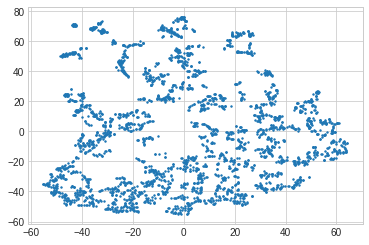

In [12]:
tsne = TSNE(random_state=0).fit_transform(features.values)

plt.scatter(*tsne.T, s=2)

100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


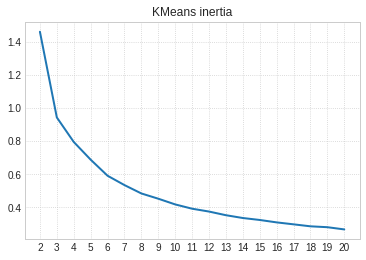

In [13]:
plot_inertia(features)

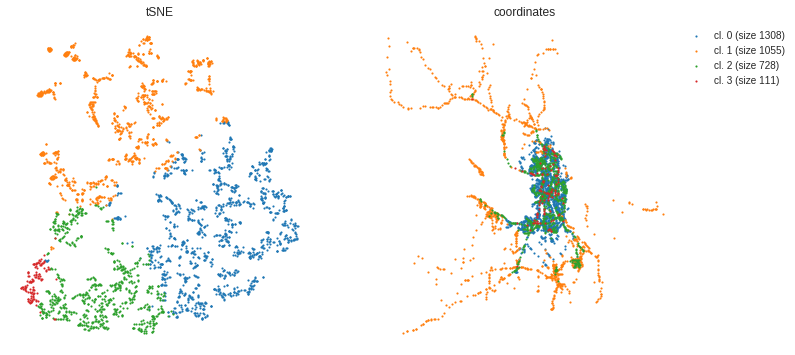

In [25]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(features)
clusters = kmeans.predict(features)

plot_clusters(clusters, tsne, coords)

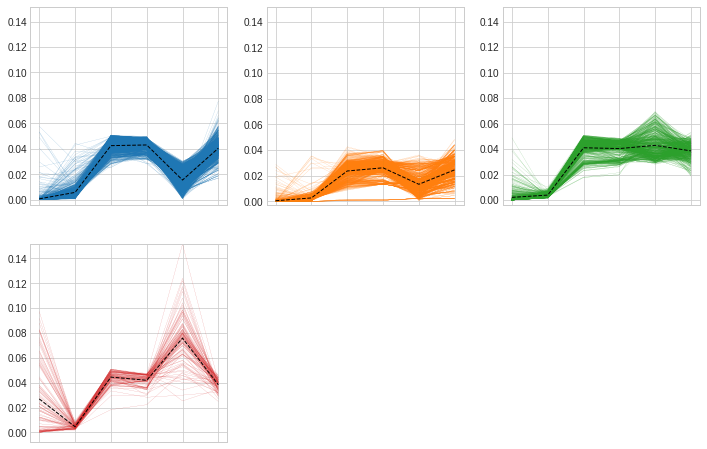

In [26]:
plot_separate_clusters(
    features=features,
    clusters=clusters,
)

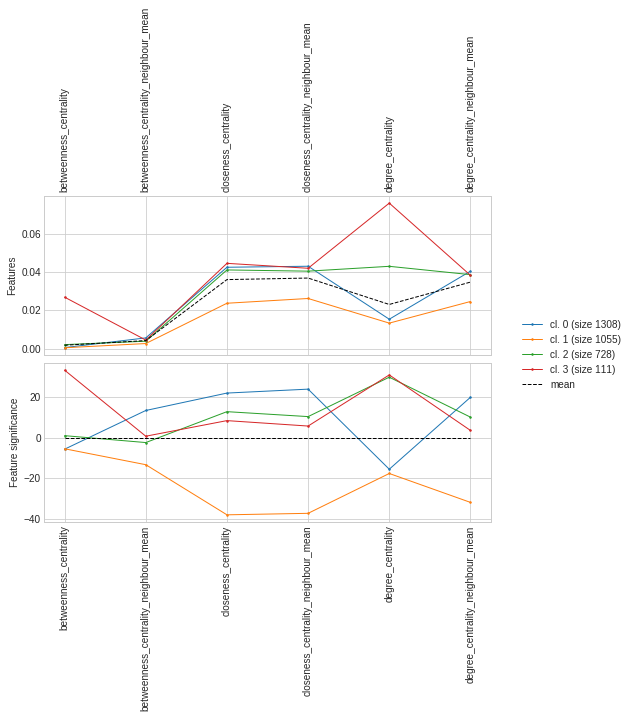

In [27]:
plot_cluster_features(
    features=features,
    clusters=clusters,
)

In [32]:
colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}

In [33]:
supernode_clusters = pd.Series(clusters, index=features.index).apply(colors.get)

supernode_clusters.head(2)

id
0    red
1    red
dtype: object

In [34]:
both_clusters = pd.DataFrame({
    'supernode': supernode_clusters,
    'infrastructure': infrastructure_clusters['cluster_name'],
})

both_clusters['count'] = 1

contingency_table = both_clusters.groupby(['supernode', 'infrastructure'])['count'].sum().reset_index()\
    .pivot(index='supernode', columns='infrastructure', values='count').T

# contingency_table /= contingency_table.sum()

contingency_table

supernode,blue,green,orange,red
infrastructure,,,,
city_center,410,251,45,74
industrial_area,135,41,33,1
infrastructureless_area,80,14,445,1
residential_area_bad,118,75,271,2
residential_area_good,528,333,212,30
tourism_area,37,14,49,3
